In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "MI_20k_iso"
    # npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    # npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The MI_20k_iso data size is: (201, 2400, 2400, 1)
READING DATA DONE
The MI_20k_iso data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [3]:
step_1000grains = 22

In [4]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:01<00:00, 95.42it/s]


In [5]:
    # GB Energy information
    step_num=121
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:01<00:00, 95.11it/s] 


In [6]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 30
    curvature_limit = 0.0182
    area_limit = 100
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < area_limit or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 22827
key num end with 0


0it [00:00, ?it/s]


finish 0 with num of GBs 0, and collected num of GBs 0
key num start with 17928
key num end with 0


0it [00:00, ?it/s]


finish 1 with num of GBs 0, and collected num of GBs 0
key num start with 15315
key num end with 0


0it [00:00, ?it/s]


finish 2 with num of GBs 0, and collected num of GBs 0
key num start with 12849
key num end with 0


0it [00:00, ?it/s]


finish 3 with num of GBs 0, and collected num of GBs 0
key num start with 10792
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 54827.50it/s]


finish 4 with num of GBs 2, and collected num of GBs 0
key num start with 9309
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 113359.57it/s]


finish 5 with num of GBs 5, and collected num of GBs 1
key num start with 8283
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 136770.78it/s]


finish 6 with num of GBs 6, and collected num of GBs 3
key num start with 7359
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 102300.10it/s]


finish 7 with num of GBs 4, and collected num of GBs 4
key num start with 6606
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 139810.13it/s]


finish 8 with num of GBs 6, and collected num of GBs 5
key num start with 5992
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 200684.40it/s]


finish 9 with num of GBs 10, and collected num of GBs 6
key num start with 5577
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 170327.07it/s]


finish 10 with num of GBs 8, and collected num of GBs 6
key num start with 5143
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 211833.54it/s]


finish 11 with num of GBs 10, and collected num of GBs 6
key num start with 4697
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 287512.77it/s]


finish 12 with num of GBs 17, and collected num of GBs 7
key num start with 4453
key num end with 16


100%|██████████| 16/16 [00:00<00:00, 273913.73it/s]


finish 13 with num of GBs 16, and collected num of GBs 10
key num start with 4192
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 273117.47it/s]


finish 14 with num of GBs 14, and collected num of GBs 10
key num start with 3993
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 262144.00it/s]


finish 15 with num of GBs 13, and collected num of GBs 10
key num start with 3761
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 288676.79it/s]


finish 16 with num of GBs 17, and collected num of GBs 10
key num start with 3562
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 243652.51it/s]


finish 17 with num of GBs 14, and collected num of GBs 11
key num start with 3378
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 252434.96it/s]


finish 18 with num of GBs 13, and collected num of GBs 11
key num start with 3241
key num end with 16


100%|██████████| 16/16 [00:00<00:00, 296941.88it/s]


finish 19 with num of GBs 16, and collected num of GBs 11
key num start with 3116
key num end with 15


100%|██████████| 15/15 [00:00<00:00, 275941.05it/s]


finish 20 with num of GBs 15, and collected num of GBs 13
key num start with 2991
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 182361.04it/s]


finish 21 with num of GBs 8, and collected num of GBs 13
key num start with 2871
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 169711.72it/s]


finish 22 with num of GBs 7, and collected num of GBs 13
key num start with 2730
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 235824.32it/s]


finish 23 with num of GBs 14, and collected num of GBs 13
key num start with 2607
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 264689.09it/s]


finish 24 with num of GBs 13, and collected num of GBs 14
key num start with 2545
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 215092.51it/s]


finish 25 with num of GBs 10, and collected num of GBs 14
key num start with 2460
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 130257.89it/s]


finish 26 with num of GBs 5, and collected num of GBs 15
key num start with 2370
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 210769.05it/s]


finish 27 with num of GBs 10, and collected num of GBs 17
key num start with 2270
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 231943.08it/s]


finish 28 with num of GBs 12, and collected num of GBs 19
key num start with 2186
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 166818.91it/s]


finish 29 with num of GBs 7, and collected num of GBs 19
key num start with 2136
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 253609.08it/s]


finish 30 with num of GBs 13, and collected num of GBs 21
key num start with 2068
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 206277.25it/s]


finish 31 with num of GBs 9, and collected num of GBs 21
key num start with 2010
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 176602.27it/s]


finish 32 with num of GBs 8, and collected num of GBs 22
key num start with 1960
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 234199.72it/s]


finish 33 with num of GBs 11, and collected num of GBs 23
key num start with 1913
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 169466.83it/s]


finish 34 with num of GBs 8, and collected num of GBs 24
key num start with 1841
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 199728.76it/s]


finish 35 with num of GBs 8, and collected num of GBs 24
key num start with 1799
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 122640.47it/s]


finish 36 with num of GBs 5, and collected num of GBs 24
key num start with 1744
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 224294.33it/s]


finish 37 with num of GBs 10, and collected num of GBs 25
key num start with 1705
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 190650.18it/s]


finish 38 with num of GBs 8, and collected num of GBs 26
key num start with 1665
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 62137.84it/s]


finish 39 with num of GBs 2, and collected num of GBs 26
key num start with 1623
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 62137.84it/s]


finish 40 with num of GBs 2, and collected num of GBs 27
key num start with 1598
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 106861.25it/s]


finish 41 with num of GBs 4, and collected num of GBs 28
key num start with 1559
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 88612.06it/s]


finish 42 with num of GBs 3, and collected num of GBs 29
key num start with 1519
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 88612.06it/s]


finish 43 with num of GBs 3, and collected num of GBs 29
key num start with 1494
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 158275.62it/s]


finish 44 with num of GBs 6, and collected num of GBs 29
key num start with 1472
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 89240.51it/s]


finish 45 with num of GBs 3, and collected num of GBs 29
key num start with 1408
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 136178.70it/s]


finish 46 with num of GBs 5, and collected num of GBs 29
key num start with 1388
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 148034.26it/s]


finish 47 with num of GBs 6, and collected num of GBs 31
key num start with 1356
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 61680.94it/s]


finish 48 with num of GBs 2, and collected num of GBs 31
key num start with 1327
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 142987.64it/s]


finish 49 with num of GBs 6, and collected num of GBs 31
key num start with 1313
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]


finish 50 with num of GBs 1, and collected num of GBs 31
key num start with 1286
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 239053.60it/s]


finish 51 with num of GBs 11, and collected num of GBs 31
key num start with 1265
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 61230.72it/s]


finish 52 with num of GBs 2, and collected num of GBs 31
key num start with 1241
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 176868.24it/s]


finish 53 with num of GBs 7, and collected num of GBs 31
key num start with 1224
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 224294.33it/s]


finish 54 with num of GBs 10, and collected num of GBs 31
key num start with 1203
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 180123.48it/s]

finish 55 with num of GBs 7, and collected num of GBs 31
key num start with 1175
key num end with 11



100%|██████████| 11/11 [00:00<00:00, 229539.02it/s]


finish 56 with num of GBs 11, and collected num of GBs 31
key num start with 1148
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 129453.83it/s]

finish 57 with num of GBs 5, and collected num of GBs 32
key num start with 1136
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 80145.94it/s]


finish 58 with num of GBs 3, and collected num of GBs 32
key num start with 1126
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 193956.25it/s]


finish 59 with num of GBs 8, and collected num of GBs 32
key num start with 1098
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 130257.89it/s]


finish 60 with num of GBs 5, and collected num of GBs 33
key num start with 1082
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]

finish 61 with num of GBs 3, and collected num of GBs 33
key num start with 1073
key num end with 4



100%|██████████| 4/4 [00:00<00:00, 113359.57it/s]


finish 62 with num of GBs 4, and collected num of GBs 33
key num start with 1053
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 58254.22it/s]


finish 63 with num of GBs 2, and collected num of GBs 33
key num start with 1029
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 160291.87it/s]

finish 64 with num of GBs 6, and collected num of GBs 33
key num start with 1014
key num end with 6



100%|██████████| 6/6 [00:00<00:00, 162360.15it/s]


finish 65 with num of GBs 6, and collected num of GBs 33
key num start with 997
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


finish 66 with num of GBs 3, and collected num of GBs 34
key num start with 980
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


finish 67 with num of GBs 3, and collected num of GBs 34
key num start with 968
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 112598.77it/s]

finish 68 with num of GBs 4, and collected num of GBs 34
key num start with 953
key num end with 5



100%|██████████| 5/5 [00:00<00:00, 131896.35it/s]


finish 69 with num of GBs 5, and collected num of GBs 35
key num start with 930
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 113359.57it/s]


finish 70 with num of GBs 4, and collected num of GBs 35
key num start with 914
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 89877.94it/s]

finish 71 with num of GBs 3, and collected num of GBs 35
key num start with 893
key num end with 1



100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]


finish 72 with num of GBs 1, and collected num of GBs 35
key num start with 887
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 137970.53it/s]


finish 73 with num of GBs 5, and collected num of GBs 35
key num start with 878
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 111107.39it/s]


finish 74 with num of GBs 4, and collected num of GBs 36
key num start with 870
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

finish 75 with num of GBs 1, and collected num of GBs 36
key num start with 854
key num end with 0



0it [00:00, ?it/s]


finish 76 with num of GBs 0, and collected num of GBs 36
key num start with 832
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 58661.59it/s]


finish 77 with num of GBs 2, and collected num of GBs 36
key num start with 826
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 92521.41it/s]


finish 78 with num of GBs 3, and collected num of GBs 36
key num start with 819
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 63072.24it/s]

finish 79 with num of GBs 2, and collected num of GBs 36
key num start with 797
key num end with 1



100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]


finish 80 with num of GBs 1, and collected num of GBs 36
key num start with 797
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]


finish 81 with num of GBs 1, and collected num of GBs 36
key num start with 790
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]


finish 82 with num of GBs 1, and collected num of GBs 36
key num start with 790
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 89240.51it/s]

finish 83 with num of GBs 3, and collected num of GBs 36
key num start with 788
key num end with 1



100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]


finish 84 with num of GBs 1, and collected num of GBs 36
key num start with 778
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 89877.94it/s]


finish 85 with num of GBs 3, and collected num of GBs 36
key num start with 765
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]


finish 86 with num of GBs 1, and collected num of GBs 36
key num start with 749
key num end with 0


0it [00:00, ?it/s]

finish 87 with num of GBs 0, and collected num of GBs 36
key num start with 748
key num end with 5



100%|██████████| 5/5 [00:00<00:00, 135300.13it/s]

finish 88 with num of GBs 5, and collected num of GBs 36
key num start with 737
key num end with 0



0it [00:00, ?it/s]


finish 89 with num of GBs 0, and collected num of GBs 36
key num start with 723
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]


finish 90 with num of GBs 1, and collected num of GBs 36
key num start with 708
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]


finish 91 with num of GBs 1, and collected num of GBs 36
key num start with 705
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 89877.94it/s]

finish 92 with num of GBs 3, and collected num of GBs 36
key num start with 695
key num end with 5



100%|██████████| 5/5 [00:00<00:00, 141699.46it/s]


finish 93 with num of GBs 5, and collected num of GBs 36
key num start with 696
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 56679.78it/s]


finish 94 with num of GBs 2, and collected num of GBs 36
key num start with 689
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 82782.32it/s]


finish 95 with num of GBs 3, and collected num of GBs 36
key num start with 686
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 61680.94it/s]


finish 96 with num of GBs 2, and collected num of GBs 36
key num start with 669
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]


finish 97 with num of GBs 1, and collected num of GBs 36
key num start with 656
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 60349.70it/s]

finish 98 with num of GBs 2, and collected num of GBs 36
key num start with 654
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 85019.68it/s]

finish 99 with num of GBs 3, and collected num of GBs 37
key num start with 652
key num end with 1



100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]


finish 100 with num of GBs 1, and collected num of GBs 37
key num start with 639
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 148034.26it/s]


finish 101 with num of GBs 6, and collected num of GBs 38
key num start with 635
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 28926.23it/s]


finish 102 with num of GBs 1, and collected num of GBs 38
key num start with 632
key num end with 0


0it [00:00, ?it/s]


finish 103 with num of GBs 0, and collected num of GBs 38
key num start with 623
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]


finish 104 with num of GBs 1, and collected num of GBs 38
key num start with 621
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 115704.94it/s]


finish 105 with num of GBs 4, and collected num of GBs 38
key num start with 616
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]


finish 106 with num of GBs 3, and collected num of GBs 38
key num start with 608
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

finish 107 with num of GBs 1, and collected num of GBs 38
key num start with 600
key num end with 0



0it [00:00, ?it/s]


finish 108 with num of GBs 0, and collected num of GBs 38
key num start with 596
key num end with 0


0it [00:00, ?it/s]


finish 109 with num of GBs 0, and collected num of GBs 38
key num start with 597
key num end with 0


0it [00:00, ?it/s]


finish 110 with num of GBs 0, and collected num of GBs 38
key num start with 585
key num end with 0


0it [00:00, ?it/s]


finish 111 with num of GBs 0, and collected num of GBs 38
key num start with 585
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]


finish 112 with num of GBs 1, and collected num of GBs 38
key num start with 584
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 30174.85it/s]

finish 113 with num of GBs 1, and collected num of GBs 38
key num start with 582
key num end with 0



0it [00:00, ?it/s]


finish 114 with num of GBs 0, and collected num of GBs 38
key num start with 577
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]


finish 115 with num of GBs 1, and collected num of GBs 38
key num start with 575
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]


finish 116 with num of GBs 1, and collected num of GBs 39
key num start with 571
key num end with 0


0it [00:00, ?it/s]


finish 117 with num of GBs 0, and collected num of GBs 39
key num start with 570
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]


finish 118 with num of GBs 1, and collected num of GBs 39
key num start with 556
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

finish 119 with num of GBs 1, and collected num of GBs 39


In [7]:
len(GB_list_GBenergy_list[22])

7

In [8]:
    time_interval = 30
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 121/121 [00:00<00:00, 1593.90it/s]


In [9]:
    print("anti-c GB")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("Over all voxels")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    
    # print("Voxels on anti-c GBs")
    # normal_growth_voxel = 0
    # antic_growth_voxel = 0
    # # calculate anti-c voxels fraction
    # normal_growth_voxel = np.sum(GB_antic_list_dV_normD_list)
    # antic_growth_voxel = np.sum(GB_antic_list_dV_antiD_list)
    # print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    # print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")


anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature GBs during whole simulations is 0.0% in 277233 GBs
The ratio of norm-curvature GBs during whole simulations is 0.19730695840682747% in 277233 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 0.0% in 547 GBs
The ratio of norm-curvature GBs during whole simulations is 100.0% in 547 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 107274 and 6726
The ratio of anti-curvature voxels during whole simulations is 5.8999999999999995% in 114000 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 106247 and 4071
The ratio of anti-curvature voxels during whole simulations is 3.6902409398284957% in 110318 voxels


<Figure size 432x288 with 0 Axes>

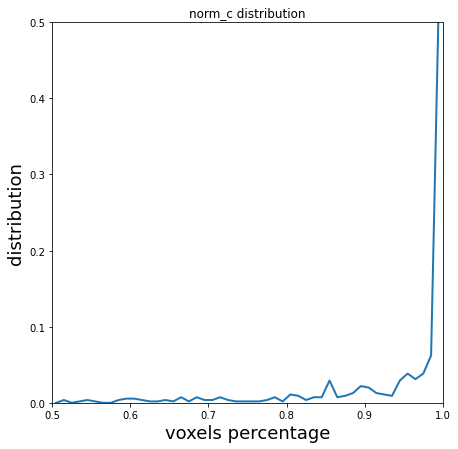

In [10]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    # figure_name_all_bin = f"figures/2D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    # plt.figure()
    # fig = plt.figure(figsize=(7, 7))
    # plt.xlim([0.5,1.0])
    # plt.ylim([0,0.5])
    # plt.title("anti_c distribution")
    # plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    # plt.xlabel("voxels percentage", fontsize=18)
    # plt.ylabel("distribution", fontsize=18)
    # # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/2D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [11]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    # print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 0.0 and 0.0

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 73075 and 41
The ratio of norm-curvature voxels during whole simulations is 99.94392472235899% in 73116 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature and norm GBs during whole simulations is 0.0% and 100.0% in 547 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature and norm GBs during whole simulations is 0.0% and 53.56489945155393% in 547 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) 0.0% and 0.10568727388153647% in 277233 GBs



1.6232492903979006


<Figure size 432x288 with 0 Axes>

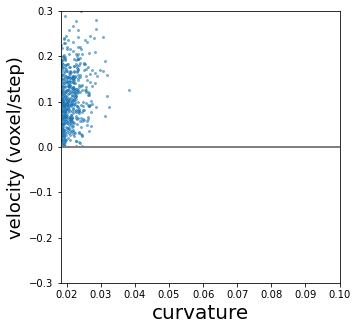

<Figure size 432x288 with 0 Axes>

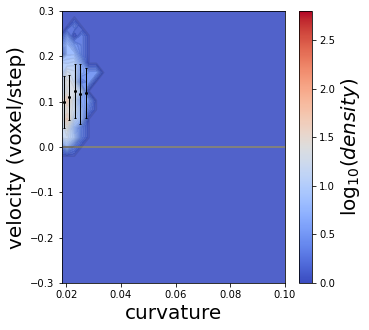

In [22]:
    # All in 1 figrue
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.105, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.4, 0.4, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plotting
    bin_interval = 0.002
    x_lim = [0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list+GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=2.8)
    ax2 = plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=2.8)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=2.8))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    print(np.max(np.log10(hist.T)))
    

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

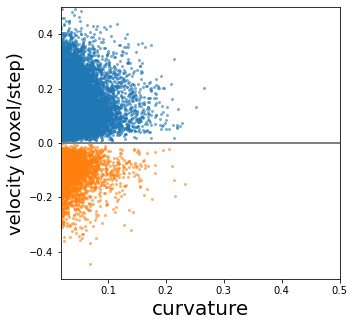

<Figure size 432x288 with 0 Axes>

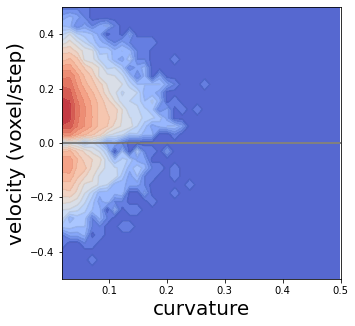

<Figure size 432x288 with 0 Axes>

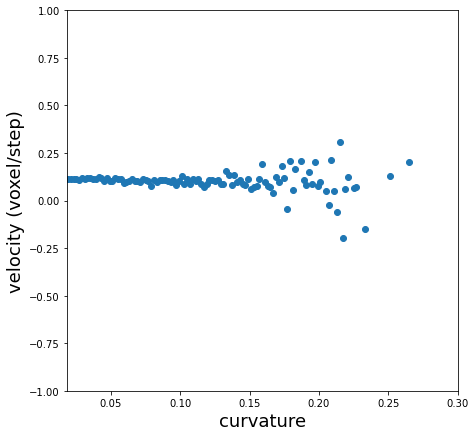

In [53]:
    # All in 1 figrue
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.505, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.6, 0.6, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.002
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = update_GB_normc_list_area_list+update_GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_curvature_1Dlist_remove_0step[index])<=x_lim[0]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

numpy.ndarray

Text(0, 0.5, 'area')

<Figure size 432x288 with 0 Axes>

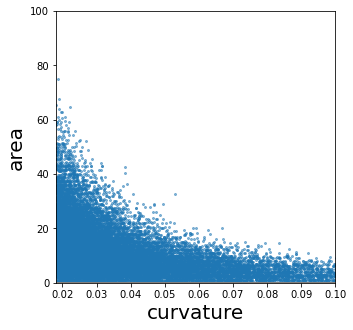

<Figure size 432x288 with 0 Axes>

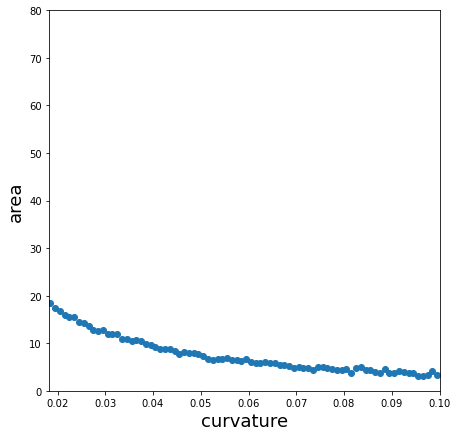

In [14]:
    # curvature VS area
    figure_name_all = f"figures/2D_signedcurvature_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(new_curvature_1Dlist_remove_0step, new_area_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("area", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([0,100])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot area VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>0.1: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        area_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_area_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: area_bin[i] = area_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_signedcurvature_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([curvature_limit,0.1])
    plt.ylim([0,80])
    plt.plot(curvature_coordinate[area_bin!=0], area_bin[area_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("area", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

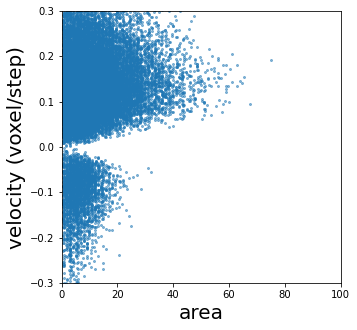

<Figure size 432x288 with 0 Axes>

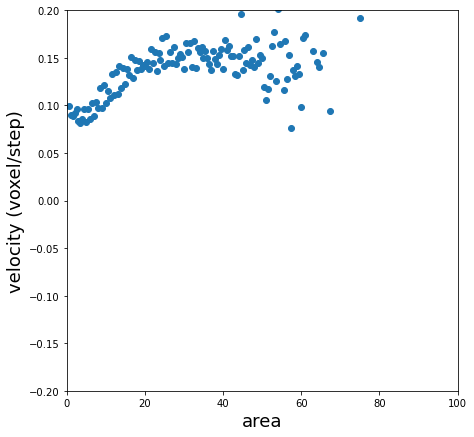

In [15]:
    # velocity VS area
    figure_name_all = f"figures/2D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.plot([0,100],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(new_area_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([0,100])
    plt.ylim([-0.3,0.3])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS area
    bin_interval = 0.1
    x_lim = [0.0,100]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(new_area_1Dlist_remove_0step)):
        if abs(new_area_1Dlist_remove_0step[index])>x_lim[1]: continue
        area_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,100])
    plt.ylim([-0.2,0.2])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'anti-curvature fraction')

<Figure size 432x288 with 0 Axes>

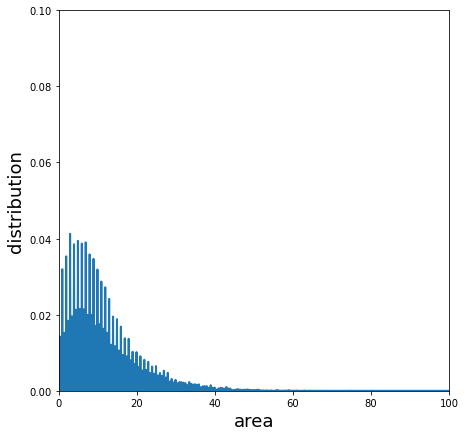

<Figure size 432x288 with 0 Axes>

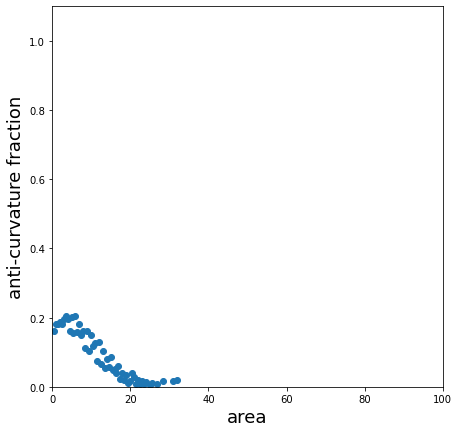

In [16]:
    # anti-c fraction VS area bin
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,100])
    plt.ylim([0,0.1])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,100])
    plt.ylim([0,1.1])
    plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)

Text(0, 0.5, 'distribution')

<Figure size 432x288 with 0 Axes>

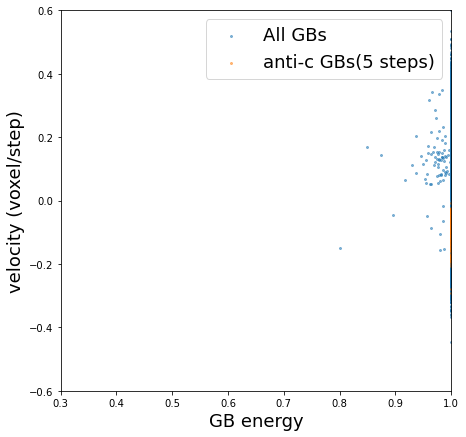

<Figure size 432x288 with 0 Axes>

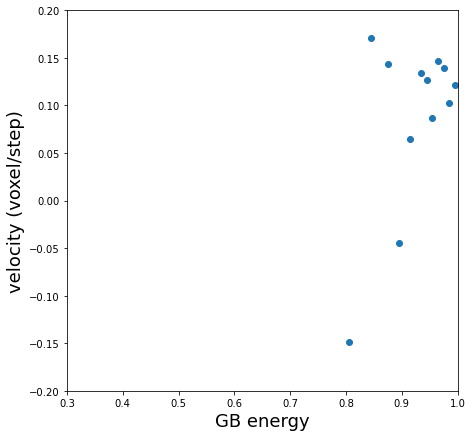

<Figure size 432x288 with 0 Axes>

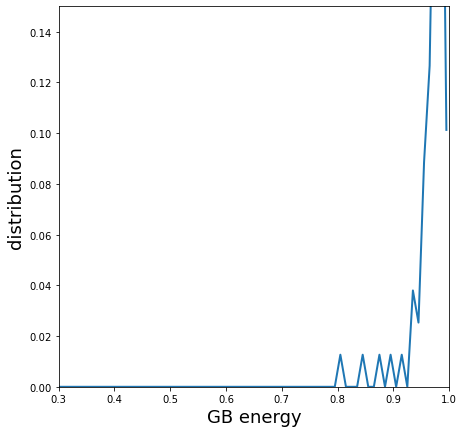

In [17]:

    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(new_GBenergy_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    update_GB_antic_list_GBenergy_list = np.array(update_GB_antic_list_GBenergy_list)
    update_GB_antic_list_velocity_list = np.array(update_GB_antic_list_velocity_list)
    update_GB_antic_list_anticNum_list = np.array(update_GB_antic_list_anticNum_list)
    plt.scatter(update_GB_antic_list_GBenergy_list[update_GB_antic_list_anticNum_list>=5], update_GB_antic_list_velocity_list[update_GB_antic_list_anticNum_list>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)


<Figure size 432x288 with 0 Axes>

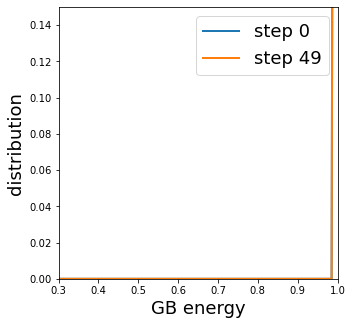

<Figure size 432x288 with 0 Axes>

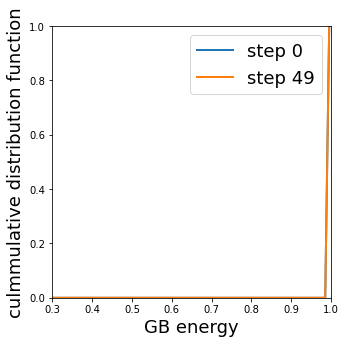

In [18]:
    # distribution for init and end
    figure_name_distri = f"figures/2D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = -1
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="step 0")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label="step 49")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/2D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = -1
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="step 0")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label="step 49")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("culmmulative distribution function", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


In [33]:
GBenergy_bin_first

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [28]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter((update_GB_antic_list_curvature_AllList+update_GB_normc_list_curvature_AllList)[time_step], (update_GB_antic_list_velocity_AllList+update_GB_normc_list_velocity_AllList)[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len((update_GB_antic_list_curvature_AllList+update_GB_normc_list_curvature_AllList)[time_step])):
            if abs((update_GB_antic_list_curvature_AllList+update_GB_normc_list_curvature_AllList)[time_step][index])>0.6: continue
            curvature_bin[int(((update_GB_antic_list_curvature_AllList+update_GB_normc_list_curvature_AllList)[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int(((update_GB_antic_list_curvature_AllList+update_GB_normc_list_curvature_AllList)[time_step][index]+0.6)//bin_interval)] += (update_GB_antic_list_velocity_AllList+update_GB_normc_list_velocity_AllList)[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

# Old code, the data name haven't been updated

The longest anti-curvature behavior is 135601364 with steps 19
The anti-curvature step 8 has velocity - -0.018 and curvature - 0.038.
The anti-curvature step 10 has velocity - -0.04 and curvature - 0.018.
The anti-curvature step 12 has velocity - -0.03 and curvature - 0.016.
The anti-curvature step 14 has velocity - -0.016 and curvature - 0.001.
The anti-curvature step 15 has velocity - -0.047 and curvature - 0.009.
The anti-curvature step 19 has velocity - -0.112 and curvature - 0.018.
The anti-curvature step 21 has velocity - -0.055 and curvature - 0.009.
The anti-curvature step 24 has velocity - -0.008 and curvature - 0.007.
The anti-curvature step 25 has velocity - -0.055 and curvature - 0.007.
The anti-curvature step 29 has velocity - -0.018 and curvature - 0.013.
The anti-curvature step 31 has velocity - -0.025 and curvature - 0.024.
The anti-curvature step 33 has velocity - -0.067 and curvature - 0.036.
The anti-curvature step 34 has velocity - -0.009 and curvature - 0.013.
The 

Text(0.5, 1.0, 'GBid 135601364 step all')

<Figure size 432x288 with 0 Axes>

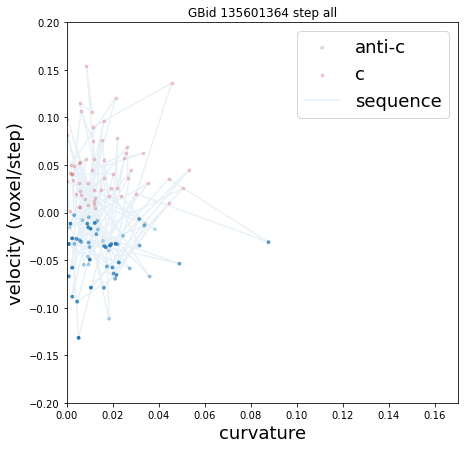

In [17]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [212]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

In [213]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [136]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [50]:
# # Plot more information for a focus GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [51]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [52]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [ ]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]
            
            
    # find the TJ around GB with anti-c behavior or low energy c behavior 
    site_energy_per_unit_focus_list = []
    site_energy_per_unit_unfocus_list = []
    for time_step in tqdm(range(step_num)):
        
        if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
        else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
        if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
        else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
        if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
        # current_GB_id = []
        # current_GB_id.extend(current_focus_GB_id)
        # current_GB_id.extend(current_unfocus_GB_id)
        current_microstructure = npy_file_aniso[time_step]
        current_energy = npy_file_aniso_energy[time_step]
        
        

        
        size_x, size_y = npy_file_aniso[time_step].shape[0:2]
        k=0
        for i in range(size_x):
            for j in range(size_y):

                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                # find window and jump over GB and grain bulk
                neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                grain_id_num_in_window = np.unique(neighboring_sites_full_list)
                if len(grain_id_num_in_window) < 3: continue
                
                # 
                do_you_find = 0
                for current_key in current_focus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_focus_list.append(site_energy/num_nei)
                        do_you_find += 1
                        break
                if do_you_find > 0: continue
                for current_key in current_unfocus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
                        break
                        
                
    xLim = [0,2.0]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_focus = np.zeros(binNum)
    freqArray_unfocus = np.zeros(binNum)

    for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
    for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

 10%|▉         | 12/121 [08:15<1:34:12, 51.86s/it]

In [ ]:
    freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
    freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

    plt.figure(figsize=(7,7))
    plt.plot(xCor, freqArray_focus, label='anti-c')
    plt.plot(xCor, freqArray_unfocus, label='c')
    plt.xlim([0.25,1.05])
    # plt.ylim([-0.15,0.15])
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
